Dataset info:
* https://competitions.codalab.org/competitions/35575#learn_the_details
* https://github.com/faresbougourzi/Covid-19-Infection-Percentage-Estimation-Challenge
* https://github.com/faresbougourzi/Covid-19-Infection-Percentage-Estimation-Challenge

#Libraries

In [ ]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import matplotlib.pyplot as plt
from skimage.io import imread

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import keras.utils
from keras import utils as np_utils
from tensorflow.keras.utils import to_categorical



In [ ]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers 
from tensorflow.keras.models import *

from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

import numpy as np
import pandas as pd
import os
import os.path
import PIL
import cv2
import shutil
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D ,ZeroPadding2D,AveragePooling2D,Flatten
from keras.layers import Activation
from keras.initializers import glorot_uniform
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError
import numpy as np


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Data Processing 

In [ ]:
data_df = pd.read_csv('/content/drive/MyDrive/Dataset-19/TRain_image_id.csv')
data_df.head()

,Unnamed: 0,Image_Id,Covid-19_percentage,Subject
0,0,Image_0000.png,0,0
1,1,Image_0001.png,0,0
2,2,Image_0002.png,0,0
3,3,Image_0003.png,0,0
4,4,Image_0004.png,0,0


In [ ]:
numOftrainImgs =len('/content/drive/MyDrive/Dataset-19/Train_Images') 
numOftrainImgs

46

In [ ]:
data_df.rename(columns={"Image_Id":"image", "Covid-19_percentage": "infection_percentage", "Subject": "patient_id"}, inplace = True)
data_df.head()

,Unnamed: 0,image,infection_percentage,patient_id
0,0,Image_0000.png,0,0
1,1,Image_0001.png,0,0
2,2,Image_0002.png,0,0
3,3,Image_0003.png,0,0
4,4,Image_0004.png,0,0


In [ ]:
data_df["patient_id"].value_counts()

3     72
0     60
2     60
1     57
65    43
      ..
33     8
48     6
79     4
32     3
42     2
Name: patient_id, Length: 132, dtype: int64

In [ ]:
data_df["infection_percentage"].value_counts()

0      736
2      179
3      154
1      149
4      129
      ... 
100      2
63       2
62       2
61       1
51       1
Name: infection_percentage, Length: 99, dtype: int64

Text(0.5, 1.0, 'infection_percentage Distribution')

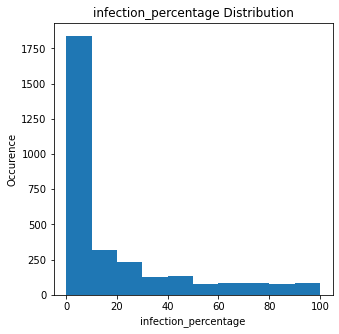

In [ ]:
import matplotlib.pyplot as plt
col="infection_percentage"
fig = plt.figure(figsize=(5,5))
plt.hist(data_df[col])
plt.ylabel("Occurence")
plt.xlabel(col)
plt.title(col+ " Distribution")

In [ ]:
data_labels = data_df[["infection_percentage"]]
data_features = data_df[["image"]]
data_features.head()

,image
0,Image_0000.png
1,Image_0001.png
2,Image_0002.png
3,Image_0003.png
4,Image_0004.png


In [ ]:
train_df, valid_df, train_labels, valid_labels = train_test_split(data_features, data_labels, test_size=0.20, random_state=0, shuffle=False)


In [ ]:
from keras.preprocessing import image
IMAGE_SIZE=224

def prepare_imgs(images_paths, in_path):
    data_size = len(images_paths)
    data_imgs_numpy = np.zeros(shape=(data_size, IMAGE_SIZE,IMAGE_SIZE,3))
    
    data_images=[]
    for i in range(0, data_size):
        imgn= 'Dataset-19/'+in_path+'/'+images_paths[i]
        img_path = os.path.join(path,imgn)
        originalImg = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        numpy_image = image.img_to_array(originalImg)
        numpy_image /= 255.0    
        data_imgs_numpy[i,:] = numpy_image

    return data_imgs_numpy

In [ ]:
batch_size = 64
 
def gen_function(data, targets, in_path="Train"):
  numOfBatchs = len(data)//batch_size
  #print("numOfBatchs:", numOfBatchs)
  x = np.zeros((batch_size, IMAGE_SIZE, IMAGE_SIZE, 3))
  y = np.zeros((batch_size,1))  

  current_batch = -1
  while True:
    current_batch += 1
    current_batch = current_batch % numOfBatchs

    start = current_batch * batch_size
    end = start + batch_size 

    da = data[start:end]
    la = targets[start:end]

    x= prepare_imgs(list(da['image']), in_path)
    y= np.array(la)

    #print (x.shape)
    #break
    
    yield x, y



class Generator():
  
  def __init__(self,data, targets, in_path):
    self.data = data
    self.targets = targets
    self.len = len(data) // batch_size
    self.gen = gen_function(self.data, self.targets, in_path)
 

#ResNet152V2 Model

In [ ]:
!pip install --upgrade git+https://github.com/broadinstitute/keras-resnet
import keras
import keras_resnet

  Cloning https://github.com/broadinstitute/keras-resnet to /tmp/pip-req-build-1ypa0wfe
  Running command git clone -q https://github.com/broadinstitute/keras-resnet /tmp/pip-req-build-1ypa0wfe
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=22164 sha256=378927eefaeaf4867efdb4130b7667a0f615ea0d3af58e1bcf685b903708636a
  Stored in directory: /tmp/pip-ephem-wheel-cache-v64aggip/wheels/f8/b9/f8/64a22c5e939a33ab49bffa0c96b23be2e66f84693b17ff512b
Successfully built keras-resnet


In [ ]:


def create_ResNet152V2_model():
  input_tensor = Input(shape=(224, 224, 3))
  base_model = ResNet152V2(input_shape = (224, 224, 3), # Shape of our images
  include_top = False, # Leave out the last fully connected layer
  weights = 'imagenet')

  for layer in base_model.layers:
      layer.trainable = False

  x = base_model.output

  x = ZeroPadding2D((7, 7))(input_tensor)
    
   # Flatten the output layer to 1 dimension
  x = layers.Flatten()(base_model.output)

  # Add a fully connected layer with 512 hidden units and ReLU activation
  x = layers.Dense(512, activation='sigmoid')(x)

  # Add a dropout rate of 0.5
  x = layers.Dropout(0.5)(x)

  # Add a final layer for regression
  x = layers.Dense(1, kernel_initializer='normal',activation='linear')(x)

  model = Model(base_model.input, x)
  return model



In [ ]:
def create_model(model_type="ResNet152V2"):

  if (model_type == "ResNet152V2"):
    model = create_ResNet152V2_model ()
    
  return model

In [ ]:
model = create_model("ResNet152V2") 
model.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                  

In [ ]:
train_gen = Generator(train_df, train_labels,"Train_Images")
valid_gen = Generator(valid_df, valid_labels,"Train_Images")

Total params: 48,018,209
Trainable params: 26,215,425
Non-trainable params: 21,802,784
__________________________________________________________________________________________________


In [ ]:
path ='/content/drive/MyDrive'
modelname = "draft.h5"# "new_"+mdl+"_"+opt+ "_"+str(lr)+".h5"

if os.path.isfile(modelname):
  model.load_weights(modelname)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

#RMSprop,

model.compile(loss = 'mean_absolute_error', optimizer='adam', metrics=[MeanAbsoluteError(name="MAE")])
#model.compile(loss = 'mean_squared_error', optimizer='adam', metrics=[RootMeanSquaredError(name="rmse")])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto',
        restore_best_weights=True)     

history = model.fit(train_gen.gen, 
                    batch_size = 64,
                    steps_per_epoch = 200,
                    validation_data=valid_gen.gen, 
                    validation_steps= valid_gen.len,
                    epochs=10,
                    callbacks=[monitor]) 
 

Epoch 1/10
200/200 [==============================] - 708s 3s/step - loss: 17.5174 - MAE: 17.5174 - val_loss: 12.9235 - val_MAE: 12.9235
Epoch 2/10
200/200 [==============================] - 129s 646ms/step - loss: 17.4421 - MAE: 17.4421 - val_loss: 12.9234 - val_MAE: 12.9234
Epoch 3/10
200/200 [==============================] - 127s 640ms/step - loss: 17.2108 - MAE: 17.2108 - val_loss: 12.9262 - val_MAE: 12.9262
Epoch 4/10
200/200 [==============================] - 127s 637ms/step - loss: 17.5671 - MAE: 17.5671 - val_loss: 12.9381 - val_MAE: 12.9381
Epoch 5/10
200/200 [==============================] - 127s 636ms/step - loss: 17.6109 - MAE: 17.6109 - val_loss: 12.9233 - val_MAE: 12.9233
Epoch 6/10
200/200 [==============================] - 127s 636ms/step - loss: 17.3023 - MAE: 17.3023 - val_loss: 12.9240 - val_MAE: 12.9240
Epoch 7/10
200/200 [==============================] - 128s 644ms/step - loss: 17.5468 - MAE: 17.5468 - val_loss: 12.9248 - val_MAE: 12.9248
Epoch 8/10
200/200 [===

#predict Val

In [ ]:
import os.path
if os.path.isfile('drive/My Drive/model_1.h5')is False:
  model.save('drive/My Drive/model_1.h5')

In [ ]:
from tensorflow.keras.models import load_model
new_model = load_model('drive/My Drive/covid-19.h5')

In [ ]:
val =sorted(list(os.listdir("/content/drive/MyDrive/Dataset-19/Val"))) 
len(val)


1301

In [ ]:
from keras.preprocessing import image
val_imgs= prepare_imgs(val,"Val")

In [ ]:
val_imgs.shape

(1301, 224, 224, 3)

In [ ]:
val_pred=model.predict(val_imgs)
val_pred[10:15]

array([[0.1591434 ],
       [0.61676836],
       [0.11938172],
       [0.00754153],
       [0.13617972]], dtype=float32)

In [ ]:
val_pred =[0 if x <0 else x[0] for x in val_pred]
val_pred[10:15]

[0.1591434, 0.61676836, 0.11938172, 0.007541528, 0.13617972]

In [ ]:
#val_predect = np.argmax(val_pred)

In [ ]:
val_df=pd.DataFrame()
val_df["image"]= val
val_df["pred"]=val_pred
val_df

,image,pred
0,Image_0000.png,0.002456
1,Image_0001.png,0.002456
2,Image_0002.png,0.002456
3,Image_0003.png,0.002456
4,Image_0004.png,1.265609
...,...,...
1296,Image_1296.png,51.366066
1297,Image_1297.png,46.641800
1298,Image_1298.png,43.143360
1299,Image_1299.png,31.346205


In [ ]:
val_df.to_csv("predictions.csv",header=None, index=None)